# Poker game database construction and analytics

The following is my poker-hand "tracker" for 6-max cash games played on for the purposes of **tracking profit/loss**, **hand and table information**, as well as **player statistics and visualisations**.

The data used is csv files of data extracted from textual accounts of some of my recent online poker matches collected through Pokerstars.com.

## Poker Miniworld description
### Entities and attributes

- Entities: 
    - Table: a "table" refers to one "session" of hands, which can be of any length, at which players can come and go, but has a consistent set of blinds.
    - Hand: a hand is a round of poker after which the "positions" of players change
    - Player: this attribute contains information about the behaviour of players over the course of all hands played
    - Play: this attribute contains information about the behaviour of players in each hand
    
- Attributes: 
    - Table: name (PK), small blind, big blind, start date and time, duration estimate (this is estimated since the text files did not contain the end times of hands)
    - Hand: table name, unique hand number (PK), start date and time, number of players, positions (as a dictionary containing positions and players), winner of any pots (of which there is always a winner of the "main pot") and the size of each of the winnings
    - Player: player type (either the "hero" or a "villain"), VPIP count (the number of times a player "voluntarily puts [money] in pot") which is an important measure of play style, PFR count (the number of times a player raises pre-flop) which is another important measure of play style, and the username of the player (PK)
    - Play: username, hand number, position, starting stack, finishing stack, cards
    
The entities and attributes are labelled as follows:

*poker_table* has columns ["table_name", "small_blind", "big_blind", "table_datetime_start", "table_duration_estimate"].

*hand* has columns ["hand_table_name", "hand_datetime_start", "hand_number", "number_players", "positions", "winner_main_pot", "winner_side_pot1", "winner_side_pot2", "winner_side_pot3", "money_main_pot", "money_side_pot1", "money_side_pot2", "money_side_pot3"].

*player* has columns ["type", "hands_recorded", "vpip_count", "pfr_count","username"].

*play* has columns ["username_play", "hand_number_play","position_play", "starting_stack", "finishing_stack", "cards"].

### Relationships among entities
A *player* will *play* a *hand* at a *poker_table*.
- A row in *hand* has foreign key (FK) referencing the table_name. A table can have many hands and a hand can have just one table.
- A row in *play* has foreign key (FK) referencing the username from *player* and the hand number from *hand*. A user can have many rows in *play* but a *play* has just one user. 

### Constraints at application level
- Each hand must have a winner of the "main pot"
- Each table, hand number and username must be unique
- Each hand can have a minimum of 2 and a maximum of 6 participating players.

---


## Library and database connection
For this database I have chosen to use sqlite3.

In [1]:
import sqlite3

conn = sqlite3.connect('PokerHistory5.db')

In [2]:
import pandas as pd

hand = pd.read_csv("hand.csv",encoding='latin-1')
poker_table = pd.read_csv("poker_table.csv",encoding='latin-1')
player = pd.read_csv("player.csv",encoding='latin-1')
play = pd.read_csv("play.csv",encoding='latin-1')

In [3]:
poker_table.to_sql('poker_table_temp', con = conn, index = False)
hand.to_sql('hand_temp', con = conn, index = False) 
player.to_sql('player_temp', con = conn, index = False)
play.to_sql('play_temp', con = conn, index = False) 

## Table creation and data loading
Since I wanted to include primary and foreign keys, I have imported the csv files into "temp" tables before transferring the data into the final tables complete with keys.

In [4]:
c = conn.cursor()

In [5]:
creating_poker_table='''
CREATE TABLE poker_table (
    table_name TEXT PRIMARY KEY,
    small_blind INTEGER NOT NULL,
    big_blind INTEGER NOT NULL,
    table_datetime_start TEXT NOT NULL,
    table_duration_estimate TEXT NOT NULL)'''

creating_hand='''
CREATE TABLE hand (
    hand_table_name TEXT NOT NULL,
    hand_datetime_start TEXT NOT NULL,
    hand_number INTEGER PRIMARY KEY,
    number_players INTEGER CHECK(number_players >0 and number_players< 7),
    positions TEXT NOT NULL,
    winner_main_pot TEXT NOT NULL,
    winner_side_pot1 TEXT,
    winner_side_pot2 TEXT,
    winner_side_pot3 TEXT,
    money_main_pot INTEGER NOT NULL,
    money_side_pot1 INTEGER,
    money_side_pot2 INTEGER,
    money_side_pot3 INTEGER,
    FOREIGN KEY(hand_table_name) REFERENCES poker_table(table_name))'''

creating_player='''
CREATE TABLE player (
    type TEXT NOT NULL,
    hands_recorded INTEGER,
    vpip_count INTEGER,
    pfr_count INTEGER,
    username TEXT PRIMARY KEY)'''

creating_play='''
CREATE TABLE play (
    username_play TEXT NOT NULL,
    hand_number_play INTEGER ,
    position_play TEXT,
    starting_stack INTEGER,
    finishing_stack INTEGER,
    cards TEXT,
    FOREIGN KEY(username_play) REFERENCES player(username),
    FOREIGN KEY(hand_number_play) REFERENCES hand(hand_number))'''

In [6]:
c.execute(creating_poker_table)
conn.commit()
c.execute(creating_hand)
conn.commit()
c.execute(creating_player)
conn.commit()
c.execute(creating_play)
conn.commit()

In [7]:
transfer_data_table='''
INSERT INTO poker_table
SELECT * FROM poker_table_temp
'''
transfer_data_hand='''
INSERT INTO hand
SELECT * FROM hand_temp
'''
transfer_data_player='''
INSERT INTO player
SELECT * FROM player_temp
'''
transfer_data_play='''
INSERT INTO play
SELECT * FROM play_temp
'''

In [8]:
c.execute(transfer_data_table)
c.execute(transfer_data_hand)
c.execute(transfer_data_player)
c.execute(transfer_data_play)
c.execute("DROP TABLE poker_table_temp")
c.execute("DROP TABLE hand_temp")
c.execute("DROP TABLE player_temp")
c.execute("DROP TABLE play_temp")
conn.commit()

## Creating a view: player_statistics

A useful view for this database is one which shows important player statistics. For example, I have chosen to include the percentage of hands which were VPIP ("voluntarily put [money] in pot") and the percentage of hands which were PFR ("pre-flop raised") by the player. Finally, I included the sum of the profits made across all recorded hands for each player. 

In [9]:
creating_view_player_stats='''
CREATE VIEW IF NOT EXISTS player_statistics AS
SELECT 
    username, type, hands_recorded, vpip, pfr, profit
FROM
(SELECT 
    username,
    type, 
    hands_recorded,
    ROUND(CAST( vpip_count AS FLOAT) / CAST(hands_recorded as FLOAT) , 3) AS vpip,
    ROUND(CAST( pfr_count AS FLOAT) / CAST(hands_recorded as FLOAT) , 3) AS pfr
FROM player) t1 
INNER JOIN
(SELECT username_play, SUM(finishing_stack-starting_stack) profit
FROM play
GROUP BY play.username_play) t2
ON t1.username = t2.username_play
ORDER BY profit DESC
'''
c.execute(creating_view_player_stats)

In [10]:
player_stats=pd.DataFrame(c.execute("SELECT * FROM player_statistics").fetchall(), columns=['username', 'type', 'hands_recorded', 'vpip', 'pfr', 'profit'])
player_stats

,username,type,hands_recorded,vpip,pfr,profit
0,serioushippo677,hero,229,0.332,0.271,59399
1,theriver567,villain,17,0.588,0.353,21805
2,microfaradio 2,villain,11,0.909,0.091,21266
3,zeppelinsuar,villain,5,1.000,0.000,17577
4,penny-in-fla,villain,17,0.588,0.000,11066
...,...,...,...,...,...,...
93,caro391,villain,9,0.778,0.111,-19950
94,JGFM81,villain,5,0.600,0.000,-23082
95,ayogipa8,villain,25,0.680,0.120,-23552
96,EL FIERA1972,villain,19,0.947,0.158,-27364


## Creating triggers

I have created 3 triggers for the purposes of inserting a hand, deleting a hand and deleting a poker table.

In [11]:
create_trigger_insert_hand='''
CREATE TRIGGER after_insert_hand AFTER INSERT ON hand
BEGIN
	INSERT INTO poker_table (table_name, small_blind, big_blind, table_datetime_start,table_duration_estimate)
	VALUES (NEW.hand_table_name, 0,0, NEW.hand_datetime_start, "0:0:0");
END;'''
c.execute(create_trigger_insert_hand)

In [12]:
create_trigger_delete_hand='''
CREATE TRIGGER after_delete_hand AFTER DELETE ON hand
BEGIN 
DELETE FROM play WHERE hand_number_play=OLD.hand_number;
END;'''
c.execute(create_trigger_delete_hand)

In [13]:
create_trigger_delete_table='''CREATE TRIGGER before_delete_table BEFORE DELETE ON poker_table
BEGIN
SELECT CASE 
WHEN (SELECT COUNT(hand_table_name) FROM hand WHERE hand_table_name=OLD.table_name) > 0
THEN RAISE(ABORT,
'Cannot delete a table from poker_table if exists in hand.')
END; 
END;'''
c.execute(create_trigger_delete_table)

## Testing and demonstrations of the database

### Demonstration of after_insert_hand trigger

In [14]:
insert_hand='''
INSERT INTO hand (hand_table_name, hand_datetime_start,hand_number, number_players, positions, winner_main_pot, winner_side_pot1, winner_side_pot2, winner_side_pot3, money_main_pot, money_side_pot1,money_side_pot2, money_side_pot3)
VALUES ('test table', '2022/12/09 10:27:12', 1234, 2, '{positions}', 'test player', NULL, NULL, NULL, 1000000, NULL, NULL, NULL);
'''
c.execute(insert_hand)
print(c.execute("SELECT * FROM hand WHERE hand_table_name =  'test table'").fetchall())
print(c.execute("SELECT * FROM poker_table WHERE table_name =  'test table'").fetchall())

[('test table', '2022/12/09 10:27:12', 1234, 2, '{positions}', 'test player', None, None, None, 1000000, None, None, None)]
[('test table', 0, 0, '2022/12/09 10:27:12', '0:0:0')]


### Demonstration of after_delete_hand

In [15]:
c.execute("SELECT * FROM play WHERE hand_number_play= 240278772882").fetchall()

[]

In [16]:
c.execute("DELETE FROM hand WHERE hand_number = 240278772882")
c.execute("SELECT * FROM play WHERE hand_number_play= 240278772882").fetchall()

[]

### Demonstration of before_delete_table

In [17]:
c.execute("DELETE FROM poker_table WHERE table_name='test table';")

IntegrityError: Cannot delete a table from poker_table if exists in hand.

In [18]:
c.execute("DELETE FROM hand WHERE hand_table_name='test table'").fetchall()

[]

In [19]:
c.execute("DELETE FROM poker_table WHERE table_name='test table';")

### Displaying the cards 'shown' by a player

It is always interesting to see which sorts of hands an opponent tends to play and in which positions. The following is all instances of a player "showing" their cards at showdown (note: not all players choose to show cards at showdown).

In [20]:
query_cards='''
SELECT username_play, position_play, cards
FROM play
WHERE LENGTH(cards)>2
ORDER BY play.username_play'''

In [21]:
c.execute(query_cards).fetchall()

[('1anghel1', 'utg', "['5d', '8c']"),
 ('BadFoxNF637', 'bb', "['Qd', '5c']"),
 ('Bill22gold', 'sb', "['Ac', '6d']"),
 ('Bill22gold', 'btn', "['Kh', 'Kd']"),
 ('Bill22gold', 'bb', "['Kc', 'Ac']"),
 ('Bill22gold', 'mp', "['Jh', 'Qd']"),
 ('BlokkerII', 'sb', "['Ah', '8d']"),
 ('BlokkerII', 'co', "['7d', '3d']"),
 ('BlokkerII', 'sb', "['As', '2c']"),
 ('BlokkerII', 'sb', "['6c', 'Tc']"),
 ('Camila_CC461', 'co', "['6c', 'Kc']"),
 ('Camila_CC461', 'btn', "['5h', '4h']"),
 ('Dr.Smokealot', 'bb', "['2c', 'Ac']"),
 ('DraQ87', 'sb', "['9d', '3s']"),
 ('DraQ87', 'sb', "['Ks', 'Kd']"),
 ('DraQ87', 'utg', "['9c', 'Ts']"),
 ('DraQ87', 'bb', "['7h', '7d']"),
 ('EL FIERA1972', 'btn', "['8h', '4h']"),
 ('EL FIERA1972', 'mp', "['9h', 'Qh']"),
 ('Everclear906', 'sb', "['Jh', 'Kc']"),
 ('Everclear906', 'bb', "['Tc', 'Qc']"),
 ('Everclear906', 'btn', "['Ah', '9h']"),
 ('FKova', 'utg', "['Kc', 'Ah']"),
 ('FastJoker8R3', 'utg', "['7s', 'Qs']"),
 ('Goldbuster1', 'utg', "['Jd', 'Jh']"),
 ('GvMeTheMon1', 'utg',

It is also interesting to see which hands a player wins with.

In [22]:
query_cards_winner='''
SELECT username_play, position_play, cards
FROM play
WHERE LENGTH(cards)>2 AND username_play=(SELECT winner_main_pot FROM hand WHERE play.hand_number_play=hand.hand_number)
ORDER BY play.username_play'''

In [23]:
c.execute(query_cards_winner).fetchall()

[('Bill22gold', 'sb', "['Ac', '6d']"),
 ('Bill22gold', 'btn', "['Kh', 'Kd']"),
 ('Bill22gold', 'bb', "['Kc', 'Ac']"),
 ('Bill22gold', 'mp', "['Jh', 'Qd']"),
 ('BlokkerII', 'sb', "['Ah', '8d']"),
 ('BlokkerII', 'sb', "['6c', 'Tc']"),
 ('Camila_CC461', 'co', "['6c', 'Kc']"),
 ('DraQ87', 'sb', "['9d', '3s']"),
 ('DraQ87', 'sb', "['Ks', 'Kd']"),
 ('DraQ87', 'utg', "['9c', 'Ts']"),
 ('Everclear906', 'sb', "['Jh', 'Kc']"),
 ('Everclear906', 'btn', "['Ah', '9h']"),
 ('FastJoker8R3', 'utg', "['7s', 'Qs']"),
 ('Goldbuster1', 'utg', "['Jd', 'Jh']"),
 ('HDGaryD', 'sb', "['3s', 'Ks']"),
 ('HighAceRQ726', 'bb', "['5h', 'Ks']"),
 ('HighAceRQ726', 'utg', "['8s', '6s']"),
 ('Hydraty', 'btn', "['Ks', '3d']"),
 ('Joe F809', 'mp', "['9s', 'Js']"),
 ('KATITO430', 'utg', "['9h', 'Jh']"),
 ('LuizÃ£o993', 'mp', "['8c', 'Js']"),
 ('LuizÃ£o993', 'utg', "['7c', 'Ah']"),
 ('NIKI-Z565', 'utg', "['As', '2d']"),
 ('Renata RDV', 'utg', "['3c', 'Qd']"),
 ('Renata RDV', 'btn', "['7s', 'Tc']"),
 ('Roga D46', 'utg', "['

### Showing the profit of a player

The database user may also want to be able to track their profits and the profits of other players. The following queries select the player with the maximum profit in the player_statistics view, the profits of each hand, and the hero and the hero's profits in each hand. 

In [24]:
player_max_profit='''
SELECT username FROM player_statistics WHERE profit = (SELECT MAX(profit) FROM player_statistics)
'''
query_max_profit='''
SELECT (finishing_stack-starting_stack)
FROM play
WHERE play.username_play= (SELECT username FROM player_statistics WHERE profit = (SELECT MAX(profit) FROM player_statistics))
GROUP BY (play.hand_number_play)'''

player_hero='''
SELECT username FROM player WHERE type="hero"
'''
query_hero_profit='''
SELECT (finishing_stack-starting_stack)
FROM play
WHERE play.username_play=(SELECT username FROM player WHERE type="hero")
ORDER BY (play.hand_number_play)
'''

These queries enable the database user to plot the profit of the "hero" and the player with the largest amount of profit recorded in the database, as demonstrated below.

In [25]:
import numpy as np
from matplotlib import pyplot as plt

def plot_profit(query, player):
    query=c.execute(query).fetchall()
    player=c.execute(player).fetchall()[0][0]
    profit=[i[0] for i in query]
    profit.insert(0,0)
    profit_total=list(np.cumsum(profit))
    plt.plot(profit_total)
    plt.xlabel("Hands")
    plt.ylabel("Profit")
    plt.title("Total profit across recorded poker hands for "+player);

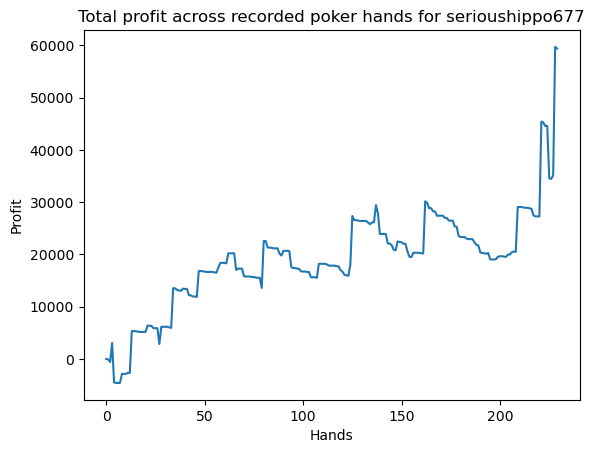

In [26]:
plot_profit(query_max_profit, player_max_profit)

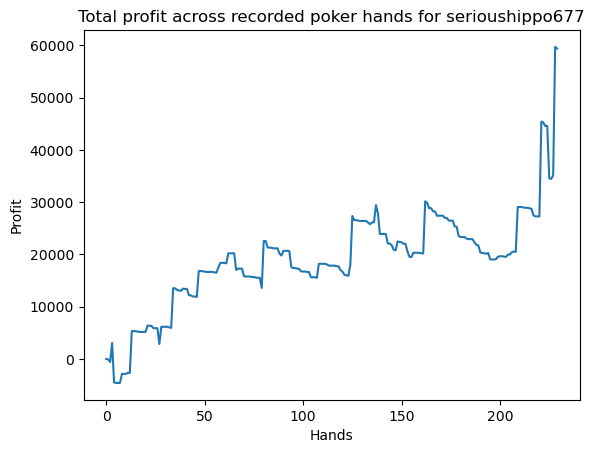

In [27]:
plot_profit(query_hero_profit,player_hero)